## Predict Price with Price, Sentiment, and Trend Analysis (BTC Only)

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.utils import to_categorical
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
import pickle

In [39]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import datetime
import seaborn as sns

### 1. Price V.S Daily Polarity

#### Linear Time Series Model

In [4]:
df_btc = pd.read_csv('data/df_3m_price_polarity.csv')
df_btc.drop(columns='Unnamed: 0', inplace=True)
df_btc

,High,Low,Open,Close,Marketcap,Close_7days,daily_avg_polarity
0,58731.142901,55604.023592,58186.508534,56048.937813,1.046793e+12,58305.963181,0.062993
1,58338.738225,55879.084195,56099.913111,58323.953580,1.089334e+12,58195.698267,0.028179
2,58937.046516,57807.863842,58326.563620,58245.003001,1.087911e+12,58032.939644,0.058156
3,61276.665366,58038.706278,58253.776809,59793.235410,1.116890e+12,58345.703392,0.120381
4,60790.555315,59289.795631,59846.230786,60204.964914,1.124636e+12,58552.333195,0.066327
...,...,...,...,...,...,...,...
86,33939.588699,32770.680780,33549.600177,33897.048590,6.354508e+11,34235.434114,0.050643
87,34909.259899,33402.696536,33854.421362,34668.548402,6.499397e+11,34590.044219,0.065517
88,35937.567147,34396.477458,34665.564866,35287.779766,6.615748e+11,34681.206387,0.073789
89,35284.344430,33213.661034,35284.344430,33746.002456,6.326962e+11,34582.873122,0.066327


In [5]:
# check correlation between daily closing price and daily average readdit sentiment
df_btc['Close'].corr(df_btc['daily_avg_polarity'])

0.09980166546878735

In [6]:
# create new dataframe with date as index 
df_btc_date = pd.read_csv('data/df_3m_price_polarity.csv')
df_btc_date['Unnamed: 0'] = pd.to_datetime(df_btc_date['Unnamed: 0'])
df_btc_date.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
df_btc_date.set_index('date', inplace=True)
df_btc_date

,High,Low,Open,Close,Marketcap,Close_7days,daily_avg_polarity
date,,,,,,,
2021-04-07,58731.142901,55604.023592,58186.508534,56048.937813,1.046793e+12,58305.963181,0.062993
2021-04-08,58338.738225,55879.084195,56099.913111,58323.953580,1.089334e+12,58195.698267,0.028179
2021-04-09,58937.046516,57807.863842,58326.563620,58245.003001,1.087911e+12,58032.939644,0.058156
2021-04-10,61276.665366,58038.706278,58253.776809,59793.235410,1.116890e+12,58345.703392,0.120381
2021-04-11,60790.555315,59289.795631,59846.230786,60204.964914,1.124636e+12,58552.333195,0.066327
...,...,...,...,...,...,...,...
2021-07-02,33939.588699,32770.680780,33549.600177,33897.048590,6.354508e+11,34235.434114,0.050643
2021-07-03,34909.259899,33402.696536,33854.421362,34668.548402,6.499397e+11,34590.044219,0.065517
2021-07-04,35937.567147,34396.477458,34665.564866,35287.779766,6.615748e+11,34681.206387,0.073789


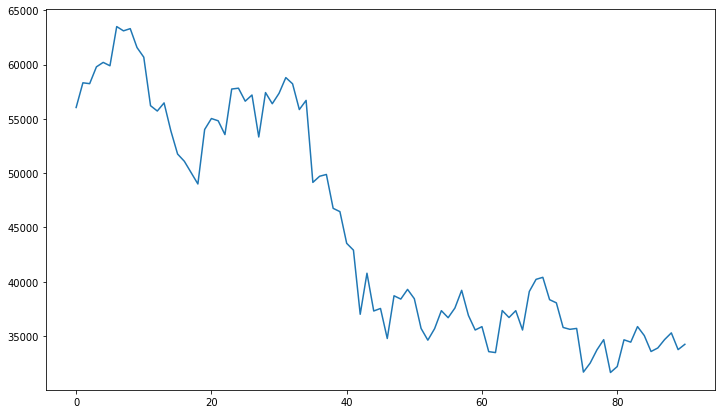

In [7]:
df_btc['Close'].plot(figsize=(12, 7));

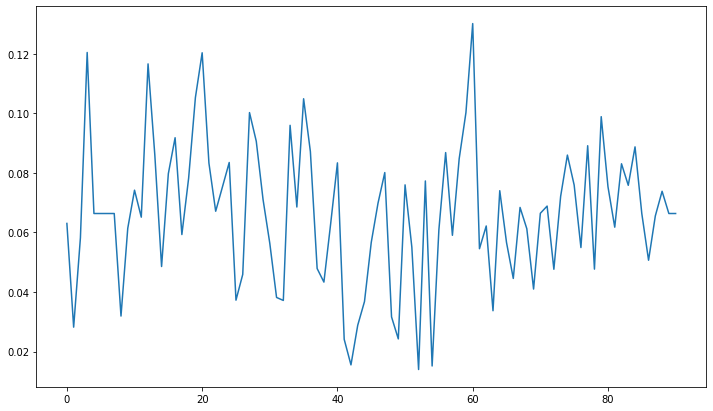

In [8]:
df_btc['daily_avg_polarity'].plot(figsize=(12, 7));

In [9]:
df_btc['lag1'] = df_btc['Close'].shift(1)
df_btc['lag2'] = df_btc['Close'].shift(2)
df_btc['lag7'] = df_btc['Close'].shift(7)
df_btc['time'] = range(0, df_btc.shape[0])
df_btc['plag1'] = df_btc['daily_avg_polarity'].shift(1)
df_btc['plag2'] = df_btc['daily_avg_polarity'].shift(2)
df_btc['plag7'] = df_btc['daily_avg_polarity'].shift(7)

In [10]:
df_btc

,High,Low,Open,Close,Marketcap,Close_7days,daily_avg_polarity,lag1,lag2,lag7,time,plag1,plag2,plag7
0,58731.142901,55604.023592,58186.508534,56048.937813,1.046793e+12,58305.963181,0.062993,NaN,NaN,NaN,0,NaN,NaN,NaN
1,58338.738225,55879.084195,56099.913111,58323.953580,1.089334e+12,58195.698267,0.028179,56048.937813,NaN,NaN,1,0.062993,NaN,NaN
2,58937.046516,57807.863842,58326.563620,58245.003001,1.087911e+12,58032.939644,0.058156,58323.953580,56048.937813,NaN,2,0.028179,0.062993,NaN
3,61276.665366,58038.706278,58253.776809,59793.235410,1.116890e+12,58345.703392,0.120381,58245.003001,58323.953580,NaN,3,0.058156,0.028179,NaN
4,60790.555315,59289.795631,59846.230786,60204.964914,1.124636e+12,58552.333195,0.066327,59793.235410,58245.003001,NaN,4,0.120381,0.058156,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,33939.588699,32770.680780,33549.600177,33897.048590,6.354508e+11,34235.434114,0.050643,33572.117653,35040.837249,31637.780055,86,0.066327,0.088694,0.098834
87,34909.259899,33402.696536,33854.421362,34668.548402,6.499397e+11,34590.044219,0.065517,33897.048590,33572.117653,32186.277671,87,0.050643,0.066327,0.075312
88,35937.567147,34396.477458,34665.564866,35287.779766,6.615748e+11,34681.206387,0.073789,34668.548402,33897.048590,34649.644588,88,0.065517,0.050643,0.061740
89,35284.344430,33213.661034,35284.344430,33746.002456,6.326962e+11,34582.873122,0.066327,35287.779766,34668.548402,34434.335314,89,0.073789,0.065517,0.083022


In [11]:
df_btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   High                91 non-null     float64
 1   Low                 91 non-null     float64
 2   Open                91 non-null     float64
 3   Close               91 non-null     float64
 4   Marketcap           91 non-null     float64
 5   Close_7days         91 non-null     float64
 6   daily_avg_polarity  91 non-null     float64
 7   lag1                90 non-null     float64
 8   lag2                89 non-null     float64
 9   lag7                84 non-null     float64
 10  time                91 non-null     int64  
 11  plag1               90 non-null     float64
 12  plag2               89 non-null     float64
 13  plag7               84 non-null     float64
dtypes: float64(13), int64(1)
memory usage: 10.1 KB


In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_btc.drop(columns=['High', 'Low', 'Open', 'Close', 'Marketcap', 'Close_7days']),
                                                   df_btc['Close'],
                                                   test_size=0.2,
                                                   shuffle=False)

In [13]:
X_train

,daily_avg_polarity,lag1,lag2,lag7,time,plag1,plag2,plag7
0,0.062993,NaN,NaN,NaN,0,NaN,NaN,NaN
1,0.028179,56048.937813,NaN,NaN,1,0.062993,NaN,NaN
2,0.058156,58323.953580,56048.937813,NaN,2,0.028179,0.062993,NaN
3,0.120381,58245.003001,58323.953580,NaN,3,0.058156,0.028179,NaN
4,0.066327,59793.235410,58245.003001,NaN,4,0.120381,0.058156,NaN
...,...,...,...,...,...,...,...,...
67,0.068364,35552.517148,37334.399526,35862.377727,67,0.044530,0.056577,0.130083
68,0.061214,39097.860897,35552.517148,33560.707838,68,0.068364,0.044530,0.054510
69,0.040970,40218.477859,39097.860897,33472.631748,69,0.061214,0.068364,0.062142
70,0.066399,40406.268987,40218.477859,37345.121486,70,0.040970,0.061214,0.033692


In [14]:
X_test

,daily_avg_polarity,lag1,lag2,lag7,time,plag1,plag2,plag7
72,0.047614,38053.504173,38347.063227,37334.399526,72,0.068818,0.066399,0.056577
73,0.072066,35787.244782,38053.504173,35552.517148,73,0.047614,0.068818,0.044530
74,0.085937,35615.869270,35787.244782,39097.860897,74,0.072066,0.047614,0.068364
75,0.075879,35698.296443,35615.869270,40218.477859,75,0.085937,0.072066,0.061214
76,0.054904,31676.693733,35698.296443,40406.268987,76,0.075879,0.085937,0.040970
77,0.089079,32505.659825,31676.693733,38347.063227,77,0.054904,0.075879,0.066399
78,0.047660,33723.028978,32505.659825,38053.504173,78,0.089079,0.054904,0.068818
79,0.098834,34662.435894,33723.028978,35787.244782,79,0.047660,0.089079,0.047614
80,0.075312,31637.780055,34662.435894,35615.869270,80,0.098834,0.047660,0.072066
81,0.061740,32186.277671,31637.780055,35698.296443,81,0.075312,0.098834,0.085937


In [15]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(72, 8)
(19, 8)
(72,)
(19,)


In [16]:
import statsmodels.api as sm

In [17]:
# Fit a statsmodel (linear model)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

X_train

,const,daily_avg_polarity,lag1,lag2,lag7,time,plag1,plag2,plag7
0,1.0,0.062993,NaN,NaN,NaN,0,NaN,NaN,NaN
1,1.0,0.028179,56048.937813,NaN,NaN,1,0.062993,NaN,NaN
2,1.0,0.058156,58323.953580,56048.937813,NaN,2,0.028179,0.062993,NaN
3,1.0,0.120381,58245.003001,58323.953580,NaN,3,0.058156,0.028179,NaN
4,1.0,0.066327,59793.235410,58245.003001,NaN,4,0.120381,0.058156,NaN
...,...,...,...,...,...,...,...,...,...
67,1.0,0.068364,35552.517148,37334.399526,35862.377727,67,0.044530,0.056577,0.130083
68,1.0,0.061214,39097.860897,35552.517148,33560.707838,68,0.068364,0.044530,0.054510
69,1.0,0.040970,40218.477859,39097.860897,33472.631748,69,0.061214,0.068364,0.062142
70,1.0,0.066399,40406.268987,40218.477859,37345.121486,70,0.040970,0.061214,0.033692


In [18]:
### Drop nulls
X_train.dropna(inplace=True)
y_train = y_train[X_train.index]

In [19]:
# instantiate the linear regression model
lm = sm.OLS(y_train, X_train)

# fit model
lm_results = lm.fit()

# display summary
print(lm_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     143.7
Date:                Wed, 25 Aug 2021   Prob (F-statistic):           1.87e-34
Time:                        12:51:45   Log-Likelihood:                -586.85
No. Observations:                  65   AIC:                             1192.
Df Residuals:                      56   BIC:                             1211.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.084e+04   5348

In [20]:
# Generate predicted tests values
lm_results.predict(X_test)

72    37251.305678
73    34881.571596
74    34903.303920
75    34547.289664
76    30860.435242
77    30916.707561
78    33154.761748
79    32349.712876
80    32388.041573
81    31309.562951
82    33437.051687
83    33802.270418
84    34727.988930
85    33882.459508
86    33433.657815
87    32726.865874
88    33151.020686
89    34105.778198
90    32438.935539
dtype: float64

In [21]:
y_test

72    35787.244782
73    35615.869270
74    35698.296443
75    31676.693733
76    32505.659825
77    33723.028978
78    34662.435894
79    31637.780055
80    32186.277671
81    34649.644588
82    34434.335314
83    35867.777735
84    35040.837249
85    33572.117653
86    33897.048590
87    34668.548402
88    35287.779766
89    33746.002456
90    34235.193451
Name: Close, dtype: float64

In [22]:
from sklearn.metrics import r2_score, mean_squared_error

In [23]:
# Check R2 and MSE scores
r2_score(y_test, lm_results.predict(X_test))

-0.6270515747662819

In [24]:
# calculate MSE
mean_squared_error(y_test, lm_results.predict(X_test))**0.5

1677.6495578219651

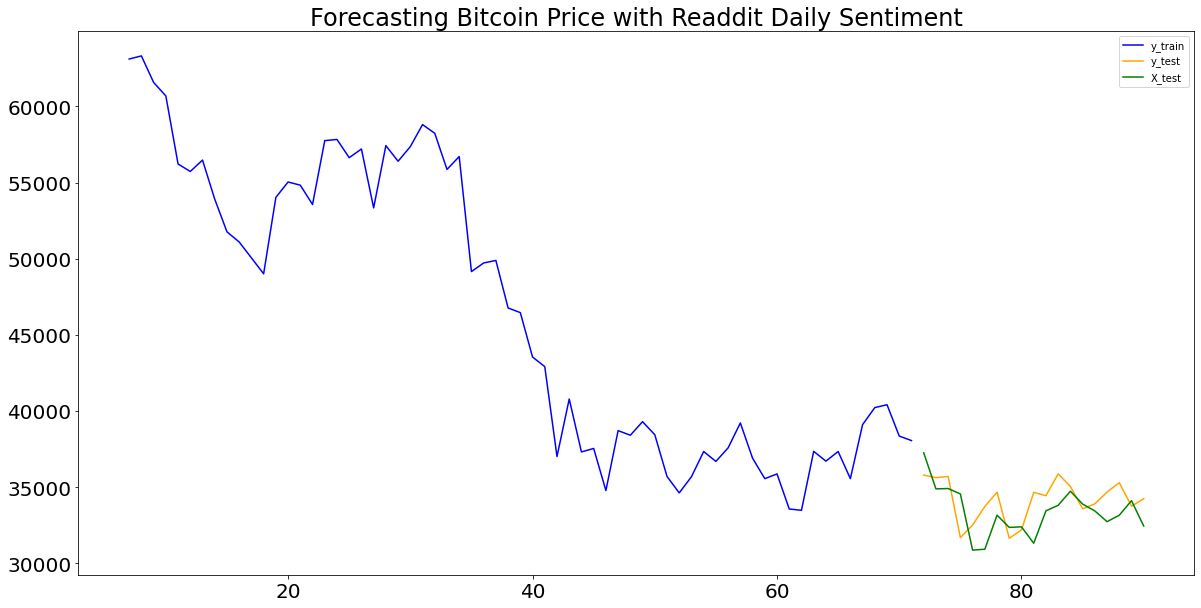

In [26]:
# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(y_train.index, y_train.values, color = 'blue', label='y_train')

# Plot testing data.
plt.plot(y_test.index, y_test.values, color = 'orange', label='y_test')

# Plot predicted test values.
plt.plot(lm_results.predict(X_test), color = 'green', label='X_test')

# Set label.
plt.title(label = 'Forecasting Bitcoin Price with Reddit Daily Sentiment', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

plt.legend()

#### ARIMA Model

In [27]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

In [28]:
df_btc_date['first_diff_close'] = df_btc_date['Close'].diff(1)
df_btc_date['second_diff_close'] = df_btc_date['Close'].diff(2)

In [29]:
df_btc_date

,High,Low,Open,Close,Marketcap,Close_7days,daily_avg_polarity,first_diff_close,second_diff_close
date,,,,,,,,,
2021-04-07,58731.142901,55604.023592,58186.508534,56048.937813,1.046793e+12,58305.963181,0.062993,NaN,NaN
2021-04-08,58338.738225,55879.084195,56099.913111,58323.953580,1.089334e+12,58195.698267,0.028179,2275.015767,NaN
2021-04-09,58937.046516,57807.863842,58326.563620,58245.003001,1.087911e+12,58032.939644,0.058156,-78.950579,2196.065188
2021-04-10,61276.665366,58038.706278,58253.776809,59793.235410,1.116890e+12,58345.703392,0.120381,1548.232409,1469.281830
2021-04-11,60790.555315,59289.795631,59846.230786,60204.964914,1.124636e+12,58552.333195,0.066327,411.729504,1959.961913
...,...,...,...,...,...,...,...,...,...
2021-07-02,33939.588699,32770.680780,33549.600177,33897.048590,6.354508e+11,34235.434114,0.050643,324.930937,-1143.788659
2021-07-03,34909.259899,33402.696536,33854.421362,34668.548402,6.499397e+11,34590.044219,0.065517,771.499812,1096.430749
2021-07-04,35937.567147,34396.477458,34665.564866,35287.779766,6.615748e+11,34681.206387,0.073789,619.231364,1390.731177


In [30]:
# Create train-test split
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(df_btc_date['daily_avg_polarity'],
                                                   df_btc_date['Close'],
                                                   test_size = 0.2,
                                                   shuffle = False)

In [31]:
y_test_p

date
2021-06-18    35787.244782
2021-06-19    35615.869270
2021-06-20    35698.296443
2021-06-21    31676.693733
2021-06-22    32505.659825
2021-06-23    33723.028978
2021-06-24    34662.435894
2021-06-25    31637.780055
2021-06-26    32186.277671
2021-06-27    34649.644588
2021-06-28    34434.335314
2021-06-29    35867.777735
2021-06-30    35040.837249
2021-07-01    33572.117653
2021-07-02    33897.048590
2021-07-03    34668.548402
2021-07-04    35287.779766
2021-07-05    33746.002456
2021-07-06    34235.193451
Name: Close, dtype: float64

/Users/emmsytsui/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/emmsytsui/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Text(0.5, 1.0, 'Bitcoin w/ Readdit Daily Polarity with ARIMA(0,2,1) Prediction')

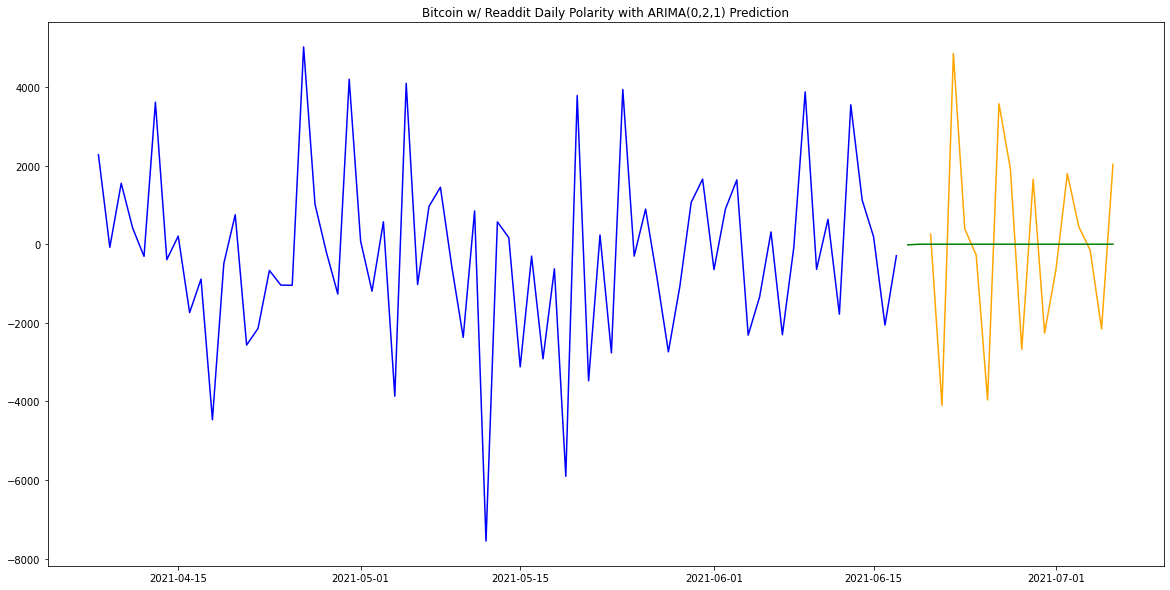

In [33]:
# Instantiate model
model_p = ARIMA(endog = y_train_p.astype(float).dropna(),
               order = (0, 2, 1))

# fit model
arima_0_2_1 = model_p.fit()

# generate predictions
preds = model_p.predict(params=arima_0_2_1.params,
                       start=datetime.datetime(2021,6,18),
                       end=datetime.datetime(2021,7,6))

# plot data
plt.figure(figsize=(20,10))

plt.plot(y_train_p.index, pd.DataFrame(y_train_p).diff(), color = 'blue') #training data
plt.plot(y_test_p.index, pd.DataFrame(y_test_p).diff().diff(), color = 'orange') #testing data
plt.plot(y_test_p.index, preds, color = 'green') #predicted test values
plt.title(label='Bitcoin w/ Readdit Daily Polarity with ARIMA(0,2,1) Prediction')

# resize tick marks
#plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)

### 2. Price & Google Trend

In [34]:
price_google_btc = pd.read_csv('data/btc_price_polarity_trend.csv')
#price_google_btc.drop(columns='Unnamed: 0', inplace=True)
price_google_btc

,date,High,Low,Open,Close,Marketcap,Close_7days,daily_avg_polarity,bitcoin
0,2021-04-07,58731.142901,55604.023592,58186.508534,56048.937813,1.046793e+12,58305.963181,0.062993,50
1,2021-04-08,58338.738225,55879.084195,56099.913111,58323.953580,1.089334e+12,58195.698267,0.028179,38
2,2021-04-09,58937.046516,57807.863842,58326.563620,58245.003001,1.087911e+12,58032.939644,0.058156,24
3,2021-04-10,61276.665366,58038.706278,58253.776809,59793.235410,1.116890e+12,58345.703392,0.120381,45
4,2021-04-11,60790.555315,59289.795631,59846.230786,60204.964914,1.124636e+12,58552.333195,0.066327,48
...,...,...,...,...,...,...,...,...,...
86,2021-07-02,33939.588699,32770.680780,33549.600177,33897.048590,6.354508e+11,34235.434114,0.050643,40
87,2021-07-03,34909.259899,33402.696536,33854.421362,34668.548402,6.499397e+11,34590.044219,0.065517,31
88,2021-07-04,35937.567147,34396.477458,34665.564866,35287.779766,6.615748e+11,34681.206387,0.073789,22
89,2021-07-05,35284.344430,33213.661034,35284.344430,33746.002456,6.326962e+11,34582.873122,0.066327,17


In [35]:
# check correlation between daily closing price and daily bitcoin google trend
price_google_btc['Close'].corr(price_google_btc['bitcoin'])

0.1824672342559044

In [41]:
# check correlation between daily closing price and daily bitcoin google trend
price_google_btc['daily_avg_polarity'].corr(price_google_btc['bitcoin'])

-0.10565512244502832

In [37]:
df_ppt = price_google_btc.drop(columns=['High', 'Low', 'Open', 'Marketcap', 'Close_7days'])
df_ppt

,date,Close,daily_avg_polarity,bitcoin
0,2021-04-07,56048.937813,0.062993,50
1,2021-04-08,58323.953580,0.028179,38
2,2021-04-09,58245.003001,0.058156,24
3,2021-04-10,59793.235410,0.120381,45
4,2021-04-11,60204.964914,0.066327,48
...,...,...,...,...
86,2021-07-02,33897.048590,0.050643,40
87,2021-07-03,34668.548402,0.065517,31
88,2021-07-04,35287.779766,0.073789,22
89,2021-07-05,33746.002456,0.066327,17


Text(0.5, 1.0, 'Correlation Between Closing Price, Daily Average Polarity, Daily Google Trend')

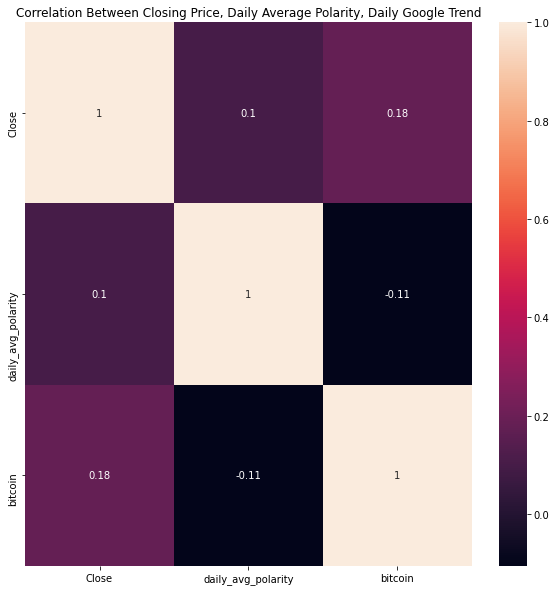

In [40]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_ppt.corr(), annot=True)
plt.title('Correlation Between Closing Price, Daily Average Polarity, Daily Google Trend')

In [139]:
price_google_btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                91 non-null     object 
 1   High                91 non-null     float64
 2   Low                 91 non-null     float64
 3   Open                91 non-null     float64
 4   Close               91 non-null     float64
 5   Marketcap           91 non-null     float64
 6   Close_7days         91 non-null     float64
 7   daily_avg_polarity  91 non-null     float64
 8   bitcoin             91 non-null     int64  
 9   lag1                90 non-null     float64
 10  lag2                89 non-null     float64
 11  lag7                84 non-null     float64
 12  time                91 non-null     int64  
 13  plag1               90 non-null     float64
 14  plag2               89 non-null     float64
 15  plag7               84 non-null     float64
dtypes: float64

In [140]:
# create new dataframe with date as index column
price_google_btc_date = pd.read_csv('data/btc_price_polarity_trend.csv')
price_google_btc_date['date'] = pd.to_datetime(price_google_btc_date['date'])
price_google_btc_date.set_index('date', inplace=True)
price_google_btc_date

,High,Low,Open,Close,Marketcap,Close_7days,daily_avg_polarity,bitcoin
date,,,,,,,,
2021-04-07,58731.142901,55604.023592,58186.508534,56048.937813,1.046793e+12,58305.963181,0.062993,50
2021-04-08,58338.738225,55879.084195,56099.913111,58323.953580,1.089334e+12,58195.698267,0.028179,38
2021-04-09,58937.046516,57807.863842,58326.563620,58245.003001,1.087911e+12,58032.939644,0.058156,24
2021-04-10,61276.665366,58038.706278,58253.776809,59793.235410,1.116890e+12,58345.703392,0.120381,45
2021-04-11,60790.555315,59289.795631,59846.230786,60204.964914,1.124636e+12,58552.333195,0.066327,48
...,...,...,...,...,...,...,...,...
2021-07-02,33939.588699,32770.680780,33549.600177,33897.048590,6.354508e+11,34235.434114,0.050643,40
2021-07-03,34909.259899,33402.696536,33854.421362,34668.548402,6.499397e+11,34590.044219,0.065517,31
2021-07-04,35937.567147,34396.477458,34665.564866,35287.779766,6.615748e+11,34681.206387,0.073789,22


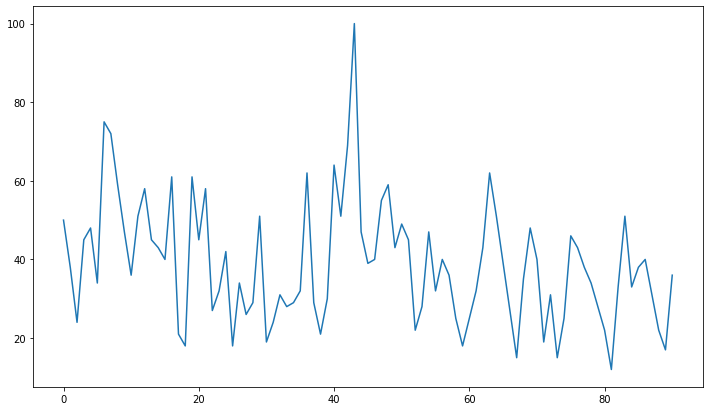

In [65]:
price_google_btc['bitcoin'].plot(figsize=(12, 7));

In [67]:
price_google_btc['lag1'] = price_google_btc['Close'].shift(1)
price_google_btc['lag2'] = price_google_btc['Close'].shift(2)
price_google_btc['lag7'] = price_google_btc['Close'].shift(7)
price_google_btc['time'] = range(0, price_google_btc.shape[0])
price_google_btc['plag1'] = price_google_btc['bitcoin'].shift(1)
price_google_btc['plag2'] = price_google_btc['bitcoin'].shift(2)
price_google_btc['plag7'] = price_google_btc['bitcoin'].shift(7)
price_google_btc

,date,High,Low,Open,Close,Marketcap,Close_7days,daily_avg_polarity,bitcoin,lag1,lag2,lag7,time,plag1,plag2,plag7
0,2021-04-07,58731.142901,55604.023592,58186.508534,56048.937813,1.046793e+12,58305.963181,0.062993,50,NaN,NaN,NaN,0,NaN,NaN,NaN
1,2021-04-08,58338.738225,55879.084195,56099.913111,58323.953580,1.089334e+12,58195.698267,0.028179,38,56048.937813,NaN,NaN,1,50.0,NaN,NaN
2,2021-04-09,58937.046516,57807.863842,58326.563620,58245.003001,1.087911e+12,58032.939644,0.058156,24,58323.953580,56048.937813,NaN,2,38.0,50.0,NaN
3,2021-04-10,61276.665366,58038.706278,58253.776809,59793.235410,1.116890e+12,58345.703392,0.120381,45,58245.003001,58323.953580,NaN,3,24.0,38.0,NaN
4,2021-04-11,60790.555315,59289.795631,59846.230786,60204.964914,1.124636e+12,58552.333195,0.066327,48,59793.235410,58245.003001,NaN,4,45.0,24.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,2021-07-02,33939.588699,32770.680780,33549.600177,33897.048590,6.354508e+11,34235.434114,0.050643,40,33572.117653,35040.837249,31637.780055,86,38.0,33.0,28.0
87,2021-07-03,34909.259899,33402.696536,33854.421362,34668.548402,6.499397e+11,34590.044219,0.065517,31,33897.048590,33572.117653,32186.277671,87,40.0,38.0,22.0
88,2021-07-04,35937.567147,34396.477458,34665.564866,35287.779766,6.615748e+11,34681.206387,0.073789,22,34668.548402,33897.048590,34649.644588,88,31.0,40.0,12.0
89,2021-07-05,35284.344430,33213.661034,35284.344430,33746.002456,6.326962e+11,34582.873122,0.066327,17,35287.779766,34668.548402,34434.335314,89,22.0,31.0,33.0


In [72]:
price_google_btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                91 non-null     object 
 1   High                91 non-null     float64
 2   Low                 91 non-null     float64
 3   Open                91 non-null     float64
 4   Close               91 non-null     float64
 5   Marketcap           91 non-null     float64
 6   Close_7days         91 non-null     float64
 7   daily_avg_polarity  91 non-null     float64
 8   bitcoin             91 non-null     int64  
 9   lag1                90 non-null     float64
 10  lag2                89 non-null     float64
 11  lag7                84 non-null     float64
 12  time                91 non-null     int64  
 13  plag1               90 non-null     float64
 14  plag2               89 non-null     float64
 15  plag7               84 non-null     float64
dtypes: float64

In [73]:
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(price_google_btc.drop(columns=['date','High', 'Low', 'Open', 'Close', 'Marketcap', 'Close_7days', 'daily_avg_polarity']),
                                                   price_google_btc['Close'],
                                                   test_size=0.2,
                                                   shuffle=False)

In [74]:
# Fit a statsmodel (linear model)
X_train_g = sm.add_constant(X_train_g)
X_test_g = sm.add_constant(X_test_g)

X_train_g

,const,bitcoin,lag1,lag2,lag7,time,plag1,plag2,plag7
0,1.0,50,NaN,NaN,NaN,0,NaN,NaN,NaN
1,1.0,38,56048.937813,NaN,NaN,1,50.0,NaN,NaN
2,1.0,24,58323.953580,56048.937813,NaN,2,38.0,50.0,NaN
3,1.0,45,58245.003001,58323.953580,NaN,3,24.0,38.0,NaN
4,1.0,48,59793.235410,58245.003001,NaN,4,45.0,24.0,NaN
...,...,...,...,...,...,...,...,...,...
67,1.0,15,35552.517148,37334.399526,35862.377727,67,27.0,39.0,25.0
68,1.0,35,39097.860897,35552.517148,33560.707838,68,15.0,27.0,32.0
69,1.0,48,40218.477859,39097.860897,33472.631748,69,35.0,15.0,43.0
70,1.0,40,40406.268987,40218.477859,37345.121486,70,48.0,35.0,62.0


In [75]:
### Drop nulls
X_train_g.dropna(inplace=True)
y_train_g = y_train_g[X_train_g.index]

In [76]:
# instantiate the linear regression model
lm_g = sm.OLS(y_train_g, X_train_g)

# fit model
lm_results_g = lm_g.fit()

# display summary
print(lm_results_g.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     138.0
Date:                Sun, 22 Aug 2021   Prob (F-statistic):           5.45e-34
Time:                        21:15:35   Log-Likelihood:                -588.10
No. Observations:                  65   AIC:                             1194.
Df Residuals:                      56   BIC:                             1214.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.074e+04   6667.737      1.611      0.1

In [77]:
# Check R2 and MSE scores
r2_score(y_test_g, lm_results_g.predict(X_test_g))

-1.1108619755029836

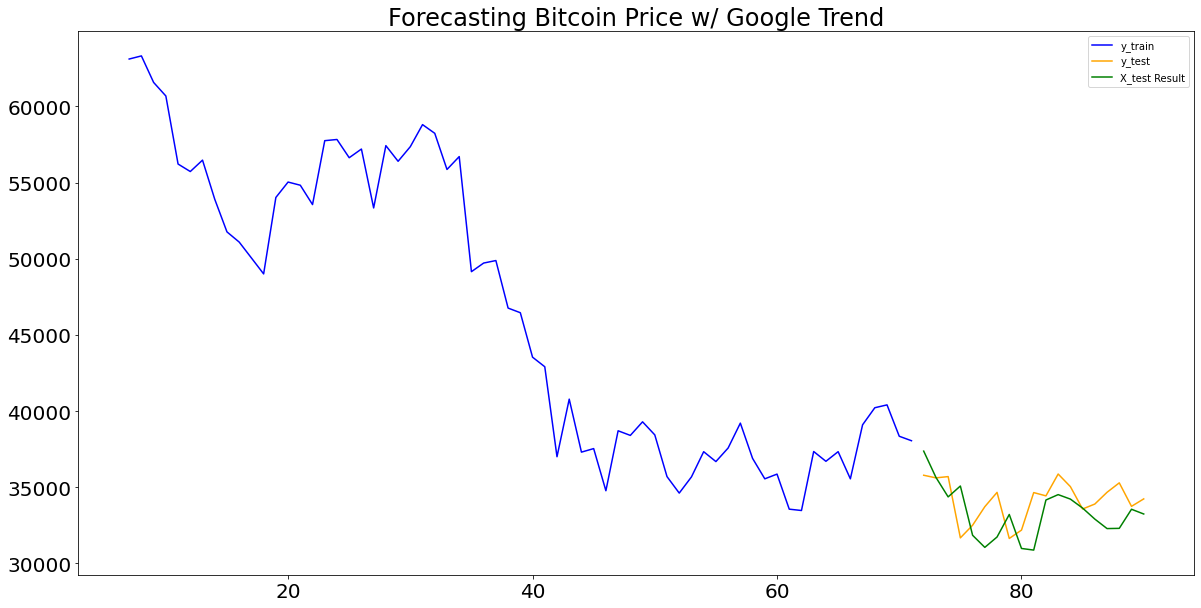

In [83]:
# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(y_train_g.index, y_train_g.values, color = 'blue', label='y_train')

# Plot testing data.
plt.plot(y_test_g.index, y_test_g.values, color = 'orange', label='y_test')

# Plot predicted test values.
plt.plot(lm_results_g.predict(X_test_g), color = 'green', label='X_test Result')

# Set label.
plt.title(label = 'Forecasting Bitcoin Price w/ Google Trend', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

plt.legend()

### ARIMA

In [141]:
price_google_btc_date

,High,Low,Open,Close,Marketcap,Close_7days,daily_avg_polarity,bitcoin
date,,,,,,,,
2021-04-07,58731.142901,55604.023592,58186.508534,56048.937813,1.046793e+12,58305.963181,0.062993,50
2021-04-08,58338.738225,55879.084195,56099.913111,58323.953580,1.089334e+12,58195.698267,0.028179,38
2021-04-09,58937.046516,57807.863842,58326.563620,58245.003001,1.087911e+12,58032.939644,0.058156,24
2021-04-10,61276.665366,58038.706278,58253.776809,59793.235410,1.116890e+12,58345.703392,0.120381,45
2021-04-11,60790.555315,59289.795631,59846.230786,60204.964914,1.124636e+12,58552.333195,0.066327,48
...,...,...,...,...,...,...,...,...
2021-07-02,33939.588699,32770.680780,33549.600177,33897.048590,6.354508e+11,34235.434114,0.050643,40
2021-07-03,34909.259899,33402.696536,33854.421362,34668.548402,6.499397e+11,34590.044219,0.065517,31
2021-07-04,35937.567147,34396.477458,34665.564866,35287.779766,6.615748e+11,34681.206387,0.073789,22


In [142]:
X_train_gd, X_test_gd, y_train_gd, y_test_gd = train_test_split(price_google_btc_date['bitcoin'],
                                                   price_google_btc_date['Close'],
                                                   test_size=0.2,
                                                   shuffle=False)

/Users/emmsytsui/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/emmsytsui/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provi

Text(0.5, 1.0, 'Bitcoin w/ Readdit Daily Polarity with ARIMA(0,2,1) Prediction')

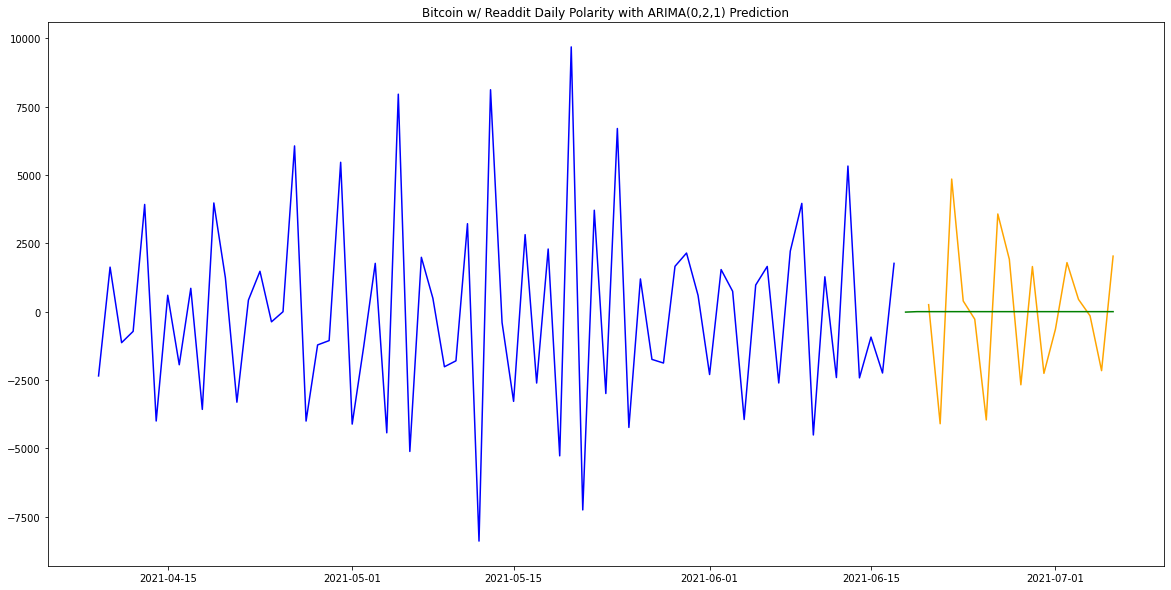

In [153]:
# Instantiate model
model_g = ARIMA(endog = y_train_gd.astype(float).dropna(),
               order = (1, 2, 1))

# fit model
arima_1_2_1 = model_g.fit()

# generate predictions
preds_g = model_g.predict(params=arima_1_2_1.params,
                       start=datetime.datetime(2021,6,18),
                       end=datetime.datetime(2021,7,6))

# plot data
plt.figure(figsize=(20,10))

plt.plot(y_train_gd.index, pd.DataFrame(y_train_gd).diff().diff(), color = 'blue') #training data
plt.plot(y_test_gd.index, pd.DataFrame(y_test_gd).diff().diff(), color = 'orange') #testing data
plt.plot(y_test_gd.index, preds, color = 'green') #predicted test values
plt.title(label='Bitcoin w/ Readdit Daily Polarity with ARIMA(0,2,1) Prediction')

# resize tick marks
#plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)